# De novo design

### Developers: Mat Bieniek, Ben Cree, Rachael Pirie, Josh Horton

* Add R-groups in user-defined positions
* Output ADMET properties
* Perform constrained optimisation
* Score poses
* Send output to free energy calculations

Open source, customisable, fast/easy to use.

In [7]:
import copy
%cd ~/rgroups2/rgroups/temp/rgroups
import prody
from rdkit import Chem
from rdkit.Chem import Draw

from rgroup import RMol, build_molecules, fix_receptor, optimise_in_receptor, RGroups, sort_conformers

[Errno 2] No such file or directory: '/home/c0065492/rgroups2/rgroups/temp/rgroups'
/home/c0065492/rgroups/rgroups/tyk2/31


In [25]:
%cd ~/rgroups/rgroups/tyk2/27
rgroup = 'flourocyclopropane-r.mol'

/home/c0065492/rgroups/rgroups/tyk2/27


In [26]:
RMol.set_gnina(loc='/home/c0065492/rgroups/rgroups/gnina')

In [28]:
!wget -nc https://files.rcsb.org/download/4GIH.pdb
pdb = '4GIH.pdb'

File ‘4GIH.pdb’ already there; not retrieving.



In [29]:
# load the complex with the ligand
sys = prody.parsePDB(pdb)
#sys = prody.parsePDB('jnk1/2gmx.pdb')

rec = sys.select('not (nucleic or hetatm) and not water')
mol = sys.select('resname XEY')
#mol = sys.select('resname 877')

prody.writePDB('rec.pdb', rec)
#prody.writePDB('lig.pdb', mol)

@> 2477 atoms and 1 coordinate set(s) were parsed in 0.04s.


'rec.pdb'

In [30]:
#!wget 'https://models.rcsb.org/v1/5nev/ligand?auth_seq_id=301&label_asym_id=E&encoding=sdf&filename=5nev_E_72L.sdf' -O lig.sdf

!obabel core.sdf -O coreh.sdf -p 7
# ^manually modify the files if need be

1 molecule converted


In [31]:
# load the ligand
# rdkit doesn't do a good job with protonation, 
#init_mol = Chem.MolFromPDBFile('lig.pdb', removeHs=False)
#init_mol = Chem.AddHs(init_mol, addCoords=True)

init_mol = Chem.SDMolSupplier('coreh.sdf', removeHs=False)[0]

# get the R group representation of the rdkit Mol
rinit_mol = RMol(init_mol)

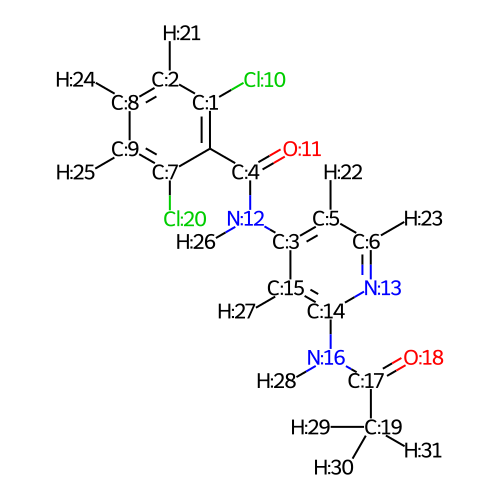

In [32]:
# select the atom to be replaced with the R group
rinit_mol.rep2D(idx=True, size=(500, 500))

In [9]:
# look up r groups and select
RGroups

In [33]:
%pwd

'/home/c0065492/rgroups/rgroups/tyk2/27'

In [34]:
R_group = Chem.MolFromMolFile(rgroup, removeHs=False)

In [35]:
# build a list of molecules
attachment_index = [31]
rmols = build_molecules(rinit_mol, attachment_index, [R_group])

Rgroup atom index <rdkit.Chem.rdchem.QueryAtom object at 0x7f6d4ef11940> neighbouring <rdkit.Chem.rdchem.Atom object at 0x7f6d4ef116a0>


In [36]:
rinit_mol.rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
rmols[0].rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

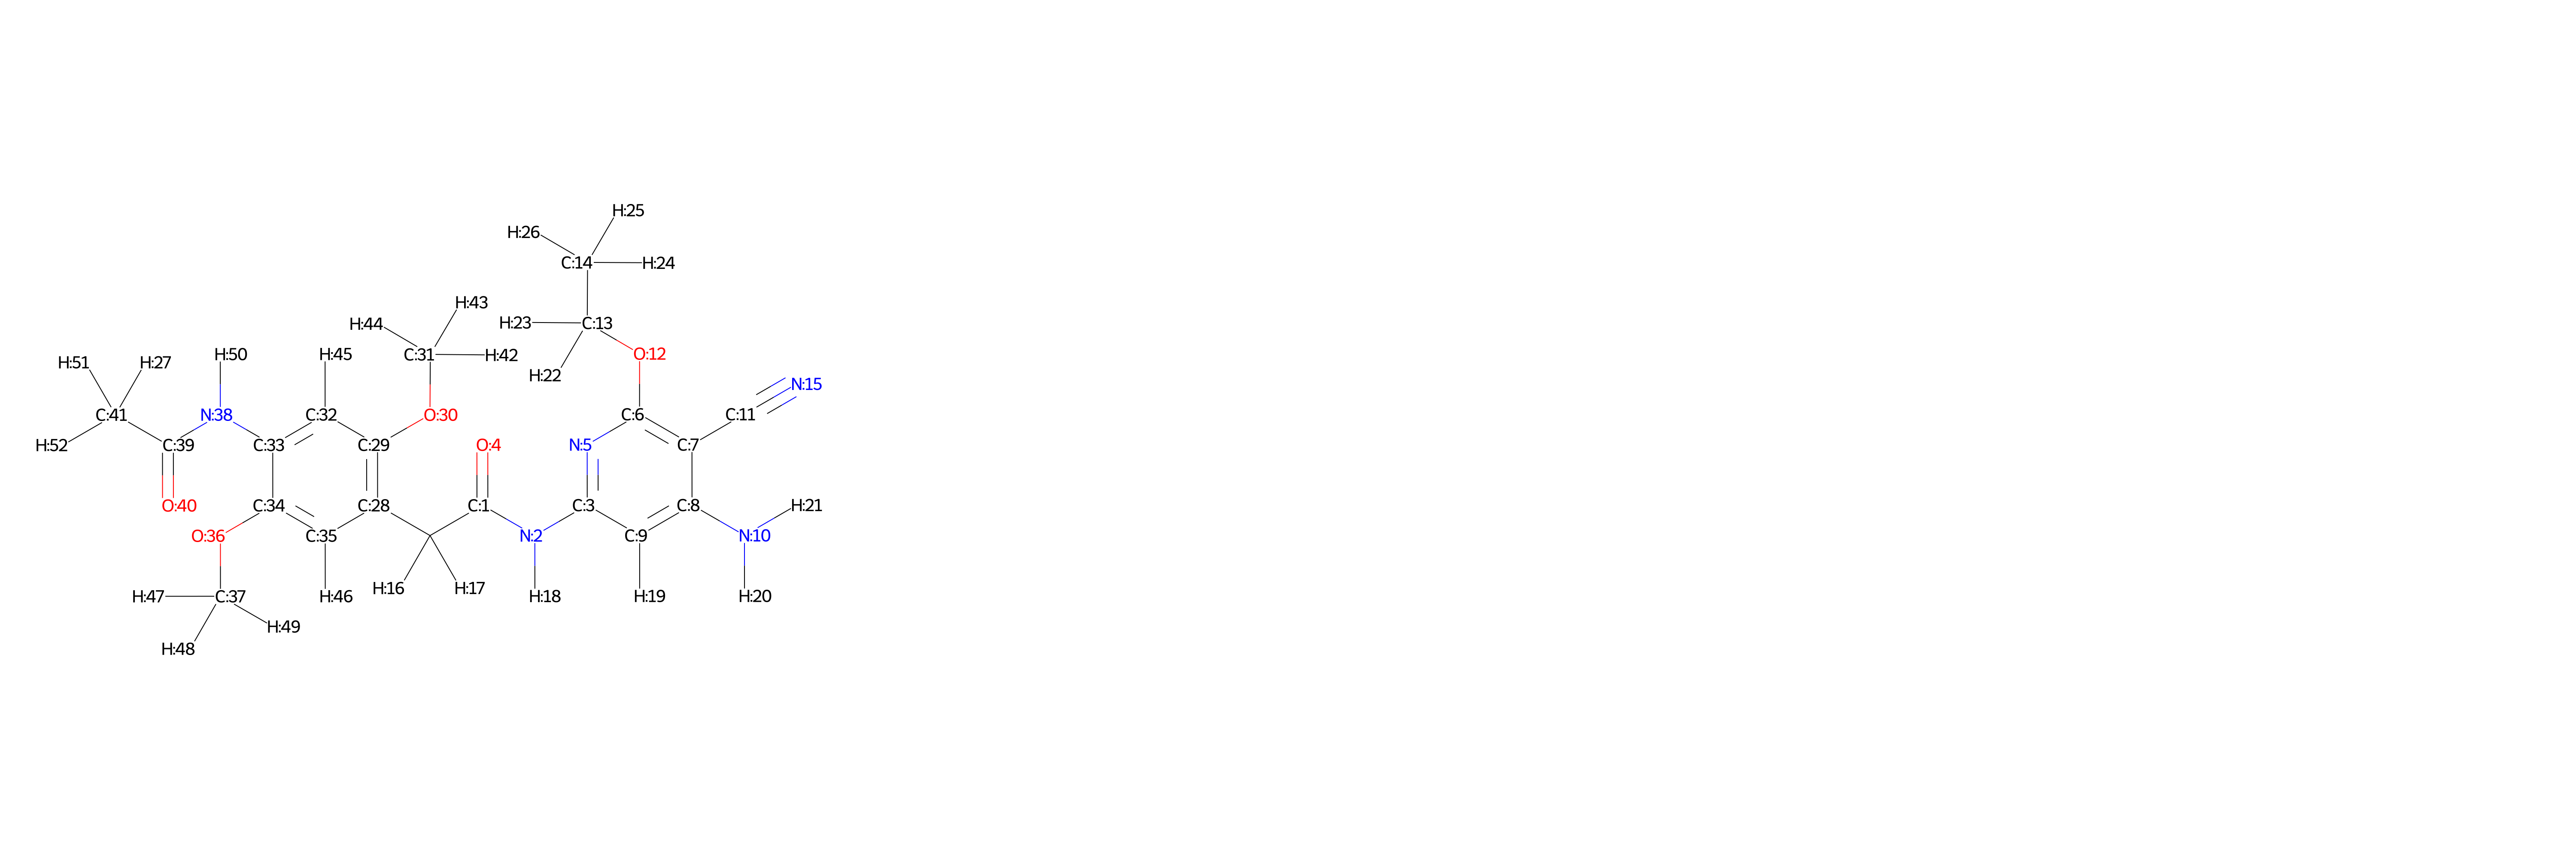

In [15]:
Draw.MolsToGridImage([mol.rep2D(rdkit_mol=True) for mol in rmols], subImgSize=(2000, 2000))


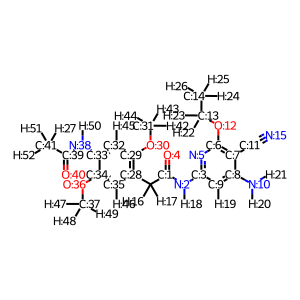

In [16]:
# take the first molecule
rmol = rmols[0]
rmol.rep2D()

In [17]:
rmol.toxicity()

MW  HBA  HBD     LogP  Pass_Ro5  has_pains  has_unwanted_subs  \
0  413.169919    8    3  2.09098      True      False              False   

   has_prob_fgs  synthetic_accessibility  
0         False                 7.899948

In [18]:
rmol.rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [19]:
rmol.generate_conformers(num_conf=50, 
                         minimum_conf_rms=0.5, 
                         flexible=[19, 29, 30])

removed 14 duplicated conformations


In [20]:
#rmol.rep3D(template=True)

In [21]:
rmol.GetNumConformers()

37

### Optimise conformers in context of protein

In [22]:
# fix the receptor file 
fix_receptor("rec.pdb", "rec_h.pdb")
# load back into prody
rec_fix = prody.parsePDB("rec_h.pdb")

@> 11973 atoms and 1 coordinate set(s) were parsed in 0.07s.


In [23]:
# filter by the protein clashes
rmol.rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [24]:
rmol.removeConfsClashingWithProdyProt(rec_fix)

Clash with the protein. Removing conformer id: 34
Clash with the protein. Removing conformer id: 33
Clash with the protein. Removing conformer id: 32
Clash with the protein. Removing conformer id: 30
Clash with the protein. Removing conformer id: 29
Clash with the protein. Removing conformer id: 28
Clash with the protein. Removing conformer id: 27
Clash with the protein. Removing conformer id: 26
Clash with the protein. Removing conformer id: 25
Clash with the protein. Removing conformer id: 24
Clash with the protein. Removing conformer id: 22
Clash with the protein. Removing conformer id: 21
Clash with the protein. Removing conformer id: 20
Clash with the protein. Removing conformer id: 19
Clash with the protein. Removing conformer id: 17
Clash with the protein. Removing conformer id: 16
Clash with the protein. Removing conformer id: 14
Clash with the protein. Removing conformer id: 13
Clash with the protein. Removing conformer id: 11
Clash with the protein. Removing conformer id: 7
C

In [25]:
rmol.rep3D(prody=rec_fix)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [26]:
opt_mol, energies = optimise_in_receptor(
     ligand=rmol, 
     receptor_file="rec_h.pdb", 
     ligand_force_field="openff", 
     use_ani=True,
     sigma_scale_factor=0.8,
     relative_permittivity=4
 )

using ani2x


Optimising conformer: 100%|█████████████████████| 12/12 [03:05<00:00, 15.47s/it]


In [27]:
type(opt_mol)

opt_mol.rep3D()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [28]:
opt_mol.to_file("jnk-opt.pdb")

In [29]:
print(energies)

[-427136.74621415645, -427148.2660525596, -427147.03984128585, -427150.610991014, -427147.0395270407, -427046.3673052902, -427148.32707034185, -427045.6051448343, -427151.5441747036, -427136.1646315316, -427043.0916579127, -427148.1162853626]


In [30]:
final_mol, final_energies = sort_conformers(ligand=opt_mol, energies=energies, energy_range=5)

In [31]:
final_mol.to_file("best_conformers_jnk.pdb")
final_mol.to_file("best_conformers_jnk.sdf")

In [32]:
print(final_energies)

[0.0, 0.9331836896017194, 3.2171043617418036, 3.278122143994551, 3.4278893410228193, 4.504333417746238, 4.504647662921343]


In [33]:
CNNscores = final_mol.gnina(receptor_file="rec_h.pdb") 
CNNscores

Gnina not found or set. Download gnina (~500MB) into /home/c0065492/rgroups2/rgroups/jnk1/18637


[6.95241, 6.92571, 7.11489, 7.11399, 7.05953, 7.09934, 7.09932]

In [34]:
def ic50(x):
    x = 10**(-x) / 10**(-9)
    print(x)

In [35]:
ic50_scores = [ic50(x) for x in CNNscores] 

111.58093595328901
118.65608092855558
76.7555874642053
76.9148150373367
87.1906670027758
79.55362979548123
79.55729345988081


In [36]:
with open('scores.dat', 'w') as f:
    for i in range(len(ic50_scores)):
        f.write(str(ic50_scores[i]))